In [3]:
import os
import shutil
import logging
import tabulate
import cloudpickle as pickle
import pandas as pd
import numpy as np
from functools import partial
import time
from pathlib import Path
import datamol as dm
from IPython.display import clear_output
from tempfile import NamedTemporaryFile, TemporaryDirectory
from itertools import combinations
from joblib import Parallel, delayed
from rdkit import Chem
from rdkit.Chem import rdFMCS
import concurrent.futures
from spyrmsd import rmsd, molecule
from espsim import GetEspSim
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

import oddt
import oddt.fingerprints
import oddt.shape
import oddt.toolkits.rdk

from HandsFreeDocking.Wrapper_Docking import PipelineDocking
from HandsFreeDocking.analysis.clustering import (
    OptimizedDBSCANClustering, PairwiseMatrixComputer, OptimizedKMedoidsClustering,
    calc_rmsd_mcs_with_timeout, calc_usr_similarity, calc_splif
)

from HandsFreeDocking.tools.Protein_Minimization import ProteinMinimizer
from HandsFreeDocking.analysis.clustering import OptimizedHierarchicalClustering

In [4]:
protein_pdb = Path("./examples/LAG3_Moloc_2.pdb")
ligands_sdf = Path("./examples/Ligands_To_Dock.sdf")
cystal_sdf = Path("./examples/Fake_Crystal.sdf")

docking_dir = Path("./examples/TMP_Docking")
docking_pkl = docking_dir / "docking_results.pkl"

# Check if all files exist
files_to_check = [protein_pdb, ligands_sdf, cystal_sdf, docking_dir]
all_files_exist = all(file.exists() for file in files_to_check)

RERUN = False

In [5]:
if RERUN == True:
    # Initialize the docking pipeline
    docking = PipelineDocking(
        workdir=docking_dir,
        docking_software=["plants", "gnina", "openeye"],      # Choose one or more: "plants", "gnina", "openeye"
        settings=(10, 4),                                     # (n_conformers, n_cpus)
        protein_pdb=protein_pdb,
        ligands_input=ligands_sdf,                            # Can be SDF or SMILES file
        crystal_sdf=cystal_sdf,
        toolkit="openeye"                                     # Choose "cdpkit" or "openeye"
    )

    # Run the docking and get results
    results = docking.run()
    FULL_DF = docking.concat_df()

    with open(docking_pkl, "wb") as f:
        pickle.dump(FULL_DF, f)

    clear_output()
else:
    with open(docking_pkl, "rb") as f:
        FULL_DF = pickle.load(f)

In [6]:
FULL_DF = FULL_DF[~FULL_DF['ID'].str.contains('L17')]
lig_name_series = FULL_DF["ID"].str.split("_").str[0]

FULL_DF.insert(1, "Lig_Name", lig_name_series)

In [7]:
ALL_MOLS = FULL_DF["Molecule"].tolist()

In [9]:
# Compute the distance matrix using your existing PairwiseMatrixComputer
computer = PairwiseMatrixComputer(ALL_MOLS, n_jobs=8, timeout=60)
rmsd_func = partial(calc_rmsd_mcs_with_timeout, timeout=60)
distance_matrix = computer.compute_matrix(rmsd_func)

Computing pairwise matrix for 310 molecules (47895 pairs)


Processed 100 pairs in 3.2s (31.2 pairs/s)
Processed 200 pairs in 3.4s (59.6 pairs/s)
Processed 400 pairs in 3.7s (107.4 pairs/s)
Processed 500 pairs in 3.8s (132.8 pairs/s)
Processed 300 pairs in 3.9s (77.6 pairs/s)
Processed 600 pairs in 4.1s (144.9 pairs/s)
Processed 800 pairs in 4.2s (190.3 pairs/s)
Processed 700 pairs in 4.2s (164.8 pairs/s)
Processed 900 pairs in 4.4s (203.4 pairs/s)
Processed 1100 pairs in 4.5s (246.2 pairs/s)
Processed 1000 pairs in 4.6s (219.3 pairs/s)
Processed 1200 pairs in 4.6s (261.4 pairs/s)
Processed 1300 pairs in 4.8s (268.1 pairs/s)
Processed 1400 pairs in 5.0s (282.6 pairs/s)
Processed 1500 pairs in 5.1s (295.6 pairs/s)
Processed 1600 pairs in 5.1s (311.1 pairs/s)
Processed 1700 pairs in 5.2s (325.6 pairs/s)
Processed 1800 pairs in 5.5s (328.8 pairs/s)
Processed 1900 pairs in 5.6s (342.2 pairs/s)
Processed 2100 pairs in 5.9s (358.1 pairs/s)
Processed 2200 pairs in 5.9s (373.2 pairs/s)
Processed 2300 pairs in 6.0s (385.5 pairs/s)
Processed 2000 pairs i

Computing MDS embedding from distance matrix...


/home/hitesit/mambaforge/envs/cheminf_3_11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Starting grid search for optimal hierarchical clustering parameters...
Total parameter combinations to try: 135


100%|██████████| 135/135 [00:01<00:00, 89.27it/s]


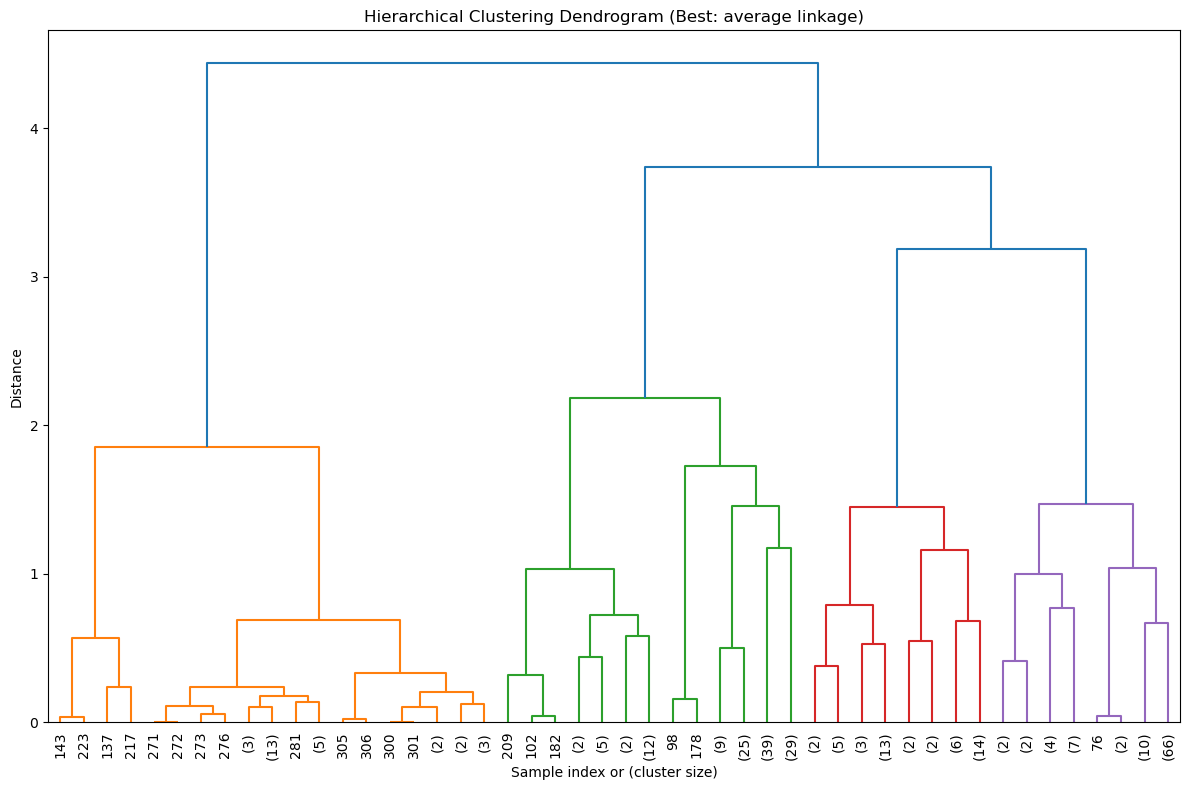

<Figure size 640x480 with 0 Axes>

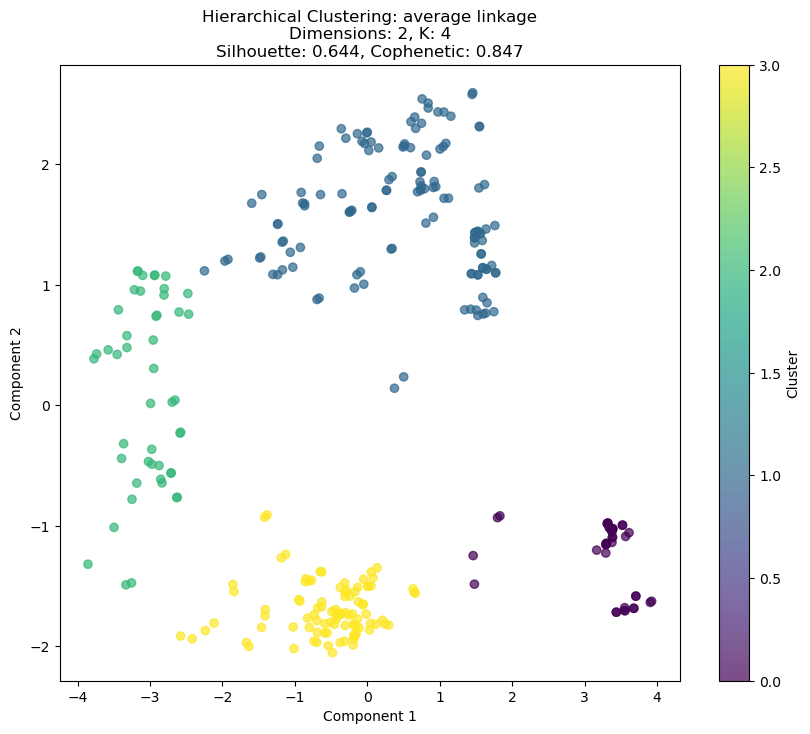


===== Hierarchical Clustering Report =====
Best silhouette score: 0.6439
Best cophenetic correlation: 0.8474
Number of clusters: 4
Best parameters:
  - Dimensionality reduction: pca
  - Dimensions: 2
  - Linkage method: average
  - K (number of clusters): 4

Silhouette score per cluster:
  - Cluster 0: 0.8062
  - Cluster 1: 0.5232
  - Cluster 2: 0.6597
  - Cluster 3: 0.7295

Top 5 parameter combinations:
1. Silhouette: 0.644, Cophenetic: 0.847, Clusters: 4, Method: pca, Dims: 2, Linkage: average, K: 4
2. Silhouette: 0.652, Cophenetic: 0.806, Clusters: 4, Method: pca, Dims: 2, Linkage: ward, K: 4
3. Silhouette: 0.652, Cophenetic: 0.806, Clusters: 4, Method: pca, Dims: 2, Linkage: complete, K: 4
4. Silhouette: 0.601, Cophenetic: 0.847, Clusters: 5, Method: pca, Dims: 2, Linkage: average, K: 5
5. Silhouette: 0.614, Cophenetic: 0.829, Clusters: 8, Method: pca, Dims: 3, Linkage: average, K: 8


In [63]:
# Initialize the hierarchical clustering
clustering = OptimizedHierarchicalClustering(
    linkage_methods=('ward', 'complete', 'average'),
    use_dimensionality_reduction=True,
    verbose=True
)

# Perform hierarchical clustering with automatic parameter optimization
labels = clustering.fit(distance_matrix)

In [69]:
# Extract clusters at different distance thresholds
tight_clusters = clustering.get_clusters_by_distance(0.4)  # More stringent similarity
loose_clusters = clustering.get_clusters_by_distance(1.5)  # More relaxed similarity

# Compare different clustering solutions
print(f"Optimal clustering has {len(np.unique(labels))} clusters")
print(f"Tight clustering has {len(np.unique(tight_clusters))} clusters")
print(f"Loose clustering has {len(np.unique(loose_clusters))} clusters")

# custom_labels = clustering.get_clusters_constrained(
#     distance_threshold=0.4,
#     min_clusters=3,
#     max_clusters=10
# )
# print(f"Custom clustering has {len(np.unique(custom_labels))} clusters")

Extracted 46 clusters at distance threshold 0.4
Extracted 7 clusters at distance threshold 1.5
Optimal clustering has 4 clusters
Tight clustering has 46 clusters
Loose clustering has 7 clusters


In [70]:
FULL_DF["Type_3"] = tight_clusters

In [71]:
from pymol import cmd
cmd.reinitialize()
cmd.load(protein_pdb)

def tmp_save(mol: Chem.rdchem.Mol):
    with NamedTemporaryFile(suffix=".sdf", delete=False) as f:
        dm.to_sdf(mol, f.name)
        return f.name

for cluster, df in FULL_DF.groupby("Type_3"):
    IDs = []
    for ndx, sub_df in df.groupby("Lig_Name"):
        sub_df.sort_values(by="Score", ascending=False, inplace=True)
        TOP = sub_df.iloc[0]
        
        ID = TOP["ID"]
        IDs.append(ID)
        TMP_MOL = tmp_save(TOP["Molecule"])
    
        cmd.load(TMP_MOL, ID)
    
    cmd.group(f"Cluster_{cluster}", " ".join(IDs))

cmd.save("TMP.pse")

## Paiwise Calculation

```python
clustering_kmed = OptimizedKMedoidsClustering(
    k_range=(2, 20),
    use_dimensionality_reduction=True,
    verbose=True
)
labels_kmed = clustering_kmed.fit(rmsd_matrix)
results_kmed = clustering_kmed.get_results()
```

```python
clustering_dbscan = OptimizedDBSCANClustering(
    eps_range=(0.5, 5.0, 0.5),
    min_samples_range=(2, 15),
    max_noise_percent=15.0,
    max_clusters = 10,
    use_dimensionality_reduction=True,
    verbose=True
)
labels_dbscan = clustering_dbscan.fit(rmsd_matrix)
results_dbscan = clustering_dbscan.get_results()
```

In [ ]:
computer = PairwiseMatrixComputer(ALL_MOLS, n_jobs=8, timeout=60)
rmsd_funct = partial(calc_rmsd_mcs_with_timeout, timeout=60)
rmsd_matrix = computer.compute_matrix(rmsd_funct)

In [ ]:
clustering_dbscan = OptimizedDBSCANClustering(
    eps_range=(0.5, 5.0, 0.5),
    min_samples_range=(2, 15),
    max_noise_percent=15.0,
    max_clusters = 10,
    use_dimensionality_reduction=True,
    verbose=True
)
labels_dbscan = clustering_dbscan.fit(rmsd_matrix)
results_dbscan = clustering_dbscan.get_results()

In [16]:
FULL_DF["Cluster_DBSCAN"] = labels_dbscan

In [36]:
from pymol import cmd
cmd.reinitialize()
cmd.load(protein_pdb)

def tmp_save(mol: Chem.rdchem.Mol):
    with NamedTemporaryFile(suffix=".sdf", delete=False) as f:
        dm.to_sdf(mol, f.name)
        return f.name

for cluster, df in FULL_DF.groupby("Cluster_DBSCAN"):
    IDs = []
    for ndx, sub_df in df.groupby("Lig_Name"):
        sub_df.sort_values(by="Score", ascending=False, inplace=True)
        TOP = sub_df.iloc[0]
        
        ID = TOP["ID"]
        IDs.append(ID)
        TMP_MOL = tmp_save(TOP["Molecule"])
    
        cmd.load(TMP_MOL, ID)
    
    cmd.group(f"Cluster_{cluster}", " ".join(IDs))

cmd.save("TMP.pse")

## Protein Minimization

In [2]:
from HandsFreeDocking.tools.Protein_Minimization import ProteinMinimizer

```python
protein_minimizer = ProteinMinimizer(FULL_DF, "Molecule", "PDB_Path")
protein_minimizer(protein_pdb, protein_pdb)
```